# Topic Modeling

Outline:
1) LDA
2) BERTopic 
3) LLM
4) sLDA

## 1) LDA

In [2]:
import pandas as pd
# load publishers data from the corresponding file
publishers = pd.read_csv("../data/processed/publishers.csv") 

In [4]:
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# compute topic modeling for all publishers (append all the samples)
df_all = pd.concat([pd.read_csv(f"../data/processed/newspapers/sample_{re.sub(r'\\W+','_ ', pub.lower()).strip('_')}.csv") for pub in publishers['publication']], ignore_index=True)

# Tokenization and stopword removal using regex and sklearn stopwords
custom_stopwords = ENGLISH_STOP_WORDS.union({'said', 'mr', 'also'})

def tokenize_and_clean(text):
    # Keep words with 3 or more alphabetic characters
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return [t for t in tokens if t not in custom_stopwords]

df_all['tokens'] = df_all['article'].apply(tokenize_and_clean)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df_all['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_all['tokens']]

# Train LDA model
num_topics = 10
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Plot wordclouds
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    topic_words = dict(lda_model.show_topic(idx, 50))
    wc = WordCloud(width=500, height=300, background_color='white', max_words=50)
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Topic {idx + 1}', fontsize=14)
    ax.axis('off')

plt.suptitle('LDA Topics – Word Clouds', fontsize=18)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Save LDA model and dictionary
lda_model.save("../models/topic_model/lda_model.gensim")
dictionary.save("../models/topic_model/lda_dictionary.dict")

In [ ]:
from gensim import corpora, models

# Load model and dictionary
lda_model = models.LdaModel.load("../models/topic_model/lda_model.gensim")
dictionary = corpora.Dictionary.load("../models/topic_model/lda_dictionary.dict")

In [ ]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=lda_model, texts=df_all['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score (c_v): {coherence_score:.4f}')
# A score above 0.4 is generally considered good for topic coherence.

In [ ]:
from datetime import datetime
import re

# --- Assumes these exist ---
# - df['tokens'] = list of preprocessed word tokens
# - df['date'] = parsed datetime
# - df['publication'] = publisher name
# - lda_model = trained gensim LdaModel
# - dictionary = gensim Dictionary used to train the model

# Load all samples from new processed newspapers folder
df_all = pd.concat([pd.read_csv(f"../data/processed/newspapers/sample_{re.sub(r'\\W+','_ ', pub.lower()).strip('_')}.csv") for pub in publishers['publication']], ignore_index=True)

# Step 1: Convert tokens to bag-of-words
corpus = [dictionary.doc2bow(text) for text in df_all['tokens']]

# Step 2: Get topic distribution for each article
def get_topic_dist(bow):
    # Return full-length vector with zero entries where necessary
    dist = lda_model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in dist]

df_all['topic_distribution'] = [get_topic_dist(doc) for doc in corpus]

# Step 3: Unpack topic distributions into separate columns
num_topics = lda_model.num_topics
topic_cols = [f'topic_{i}' for i in range(num_topics)]
df_topics = pd.DataFrame(df_all['topic_distribution'].tolist(), columns=topic_cols)

# Step 4: Combine with metadata
df_meta = df_all[['date', 'publication']].copy()
df_combined = pd.concat([df_meta, df_topics], axis=1)
df_combined['month'] = pd.to_datetime(df_combined['date'], format='mixed', errors='coerce').dt.to_period('M')

# Step 5: Aggregate topic shares by month and publisher
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Step 6: Save to CSV
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher.csv', index=False)

print("Saved: 'monthly_topic_shares_by_publisher.csv'")

In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# --- 1. Load publisher article data ---
# Load publishers
publishers = pd.read_csv("../data/processed/publishers.csv")

# Define safe filename generator
def safe_filename(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

# Concatenate all article samples
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/sample_{safe_filename(pub)}.csv")
    for pub in publishers['publication']
], ignore_index=True)

# --- 2. Define keyword filter ---
topic_keywords = [
    "manufacturing", "factory", "production", "industry", "output",
    "supply chain", "logistics", "transport", "shortage"
]

# --- 3. Clean and filter text ---
def clean_text(text_input):
    text_input = str(text_input).lower()
    text_input = re.sub(r'\d+', '', text_input)
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)
    text_input = re.sub(r'\s+', ' ', text_input).strip()
    return text_input

def filter_keywords(text, keywords):
    text = text.lower()
    return ' '.join([
        word for word in text.split()
        if any(k in word for k in keywords)
    ])

# --- 4. Aggregate articles per month ---
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')
df_all['month'] = df_all['date'].dt.to_period('M').dt.to_timestamp()

df_monthly = df_all.groupby('month')['article'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# --- 5. Apply keyword filtering ---
df_monthly['filtered_content'] = df_monthly['article'].apply(lambda x: filter_keywords(x, topic_keywords))

# --- 6. Load IPI data and merge ---
df_indpro = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=INDPRO', parse_dates=['observation_date'])
df_indpro.rename(columns={'observation_date': 'date', 'INDPRO': 'ipi'}, inplace=True)
df_indpro['month'] = df_indpro['date'].dt.to_period('M').dt.to_timestamp()

df_keywords_monthly = pd.merge(df_monthly, df_indpro[['month', 'ipi']], on='month', how='inner')

# --- 7. TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    preprocessor=clean_text
)

X_tfidf = vectorizer.fit_transform(df_keywords_monthly['filtered_content'].fillna(''))

df_features = pd.DataFrame(
    X_tfidf.toarray(),
    columns=[f"kw_{word}" for word in vectorizer.get_feature_names_out()]
)
df_features['month'] = df_keywords_monthly['month'].values
df_features['ipi'] = df_keywords_monthly['ipi'].values

# --- 8. Save final DataFrame ---
df_features.to_csv("../data/processed/df_industry_keywords_monthly.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/newspapers/sample_reuters.csv'

## 2) BERTopic

Goal: Topic shares by month-publisher using BERTopic for the topic modeling. 

In [2]:
# Imports
import os
import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from difflib import get_close_matches
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from bertopic import BERTopic
from difflib import get_close_matches
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

# Load and clean data
publishers = pd.read_csv("../data/processed/publishers.csv")
data_dir = "../data/processed/newspapers/"
available_files = os.listdir(data_dir)

available_basenames = {
    re.sub(r'^sample_|\.csv$', '', fname): fname
    for fname in available_files
    if fname.startswith("sample_") and fname.endswith(".csv")
}

def sanitize(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

dfs = []
for pub in tqdm(publishers['publication'], desc="Loading data"):
    pub_clean = sanitize(pub)
    match = get_close_matches(pub_clean, available_basenames.keys(), n=1, cutoff=0.7)
    if match:
        dfs.append(pd.read_csv(os.path.join(data_dir, available_basenames[match[0]])))
    else:
        print(f"No file found for: {pub}")

df_all = pd.concat(dfs, ignore_index=True)

# Clean text
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return ' '.join([t for t in tokens if t not in stop_words])

df_all['clean_text'] = df_all['article'].astype(str).apply(clean_text)
df_all = df_all[df_all['clean_text'].str.split().str.len() > 20].reset_index(drop=True)

# Batched Embeddings
print("Generating text embeddings in batches...")
embed_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
texts = df_all['clean_text'].tolist()
batch_size = 10000
all_embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch = texts[i:i+batch_size]
    embeddings = embed_model.encode(batch, show_progress_bar=True)
    all_embeddings.append(embeddings)

embeddings = np.vstack(all_embeddings)

[nltk_data] Downloading package stopwords to /Users/rada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading data: 100%|██████████| 26/26 [00:08<00:00,  3.07it/s]


Generating text embeddings in batches...


Embedding batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   4%|▍         | 1/24 [00:15<05:56, 15.48s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   8%|▊         | 2/24 [00:29<05:26, 14.83s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  12%|█▎        | 3/24 [00:42<04:53, 13.98s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  17%|█▋        | 4/24 [00:55<04:31, 13.56s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  21%|██        | 5/24 [01:06<04:01, 12.71s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  25%|██▌       | 6/24 [01:20<03:52, 12.90s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  29%|██▉       | 7/24 [01:32<03:37, 12.77s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  33%|███▎      | 8/24 [01:45<03:25, 12.85s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  38%|███▊      | 9/24 [01:57<03:08, 12.57s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  42%|████▏     | 10/24 [02:10<02:56, 12.63s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  46%|████▌     | 11/24 [02:23<02:46, 12.80s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  50%|█████     | 12/24 [02:34<02:26, 12.19s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  54%|█████▍    | 13/24 [02:43<02:04, 11.34s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  58%|█████▊    | 14/24 [02:56<01:57, 11.71s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  62%|██████▎   | 15/24 [03:10<01:52, 12.49s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  67%|██████▋   | 16/24 [03:23<01:40, 12.59s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  71%|███████   | 17/24 [03:36<01:27, 12.56s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  75%|███████▌  | 18/24 [03:49<01:16, 12.79s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  79%|███████▉  | 19/24 [04:02<01:05, 13.03s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  83%|████████▎ | 20/24 [04:16<00:52, 13.22s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  88%|████████▊ | 21/24 [04:31<00:40, 13.61s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  92%|█████████▏| 22/24 [04:45<00:27, 13.93s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  96%|█████████▌| 23/24 [04:59<00:14, 14.01s/it]

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Embedding batches: 100%|██████████| 24/24 [05:14<00:00, 13.10s/it]


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

# Dimensionality reduction
umap_model = UMAP(n_components=5, random_state=42)

# KMeans clustering
num_topics = 10
kmeans_model = KMeans(n_clusters=num_topics, random_state=42)

# Initialize BERTopic
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    embedding_model=None,
    language="english",
    calculate_probabilities=True,
    verbose=True,
)

# Fit and transform
print("Fitting BERTopic...")
topics, probs = topic_model.fit_transform(texts, embeddings)

# Save results
topic_model.save("../models/topic_model/bertopic_model")
np.save("../models/topic_model/bertopic_embeddings.npy", embeddings)

Fitting BERTopic...


2025-07-15 19:21:57,971 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-15 19:25:13,703 - BERTopic - Dimensionality - Completed ✓
2025-07-15 19:25:13,707 - BERTopic - Cluster - Start clustering the reduced embeddings
Exception ignored in: <function ResourceTracker.__del__ at 0x1077ec900>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104ef0900>
Traceback (most 

In [24]:
# Get number of real topics
topic_ids = sorted([t for t in topic_model.get_topics().keys() if t != -1])
topic_cols = [f"topic_{i}" for i in topic_ids]

df_meta = df_all[['date', 'publication']].reset_index(drop=True)
df_combined = df_meta.copy()
df_combined['topic'] = topics

# Extract month
df_combined['month'] = pd.to_datetime(df_combined['date'], format='mixed', errors='coerce').dt.to_period('M')

# One-hot encode topics
df_onehot = pd.get_dummies(df_combined['topic'], prefix='topic')

# Combine with meta
df_combined = pd.concat([df_combined[['month', 'publication']], df_onehot], axis=1)

# Group by month + publisher and average (which is topic share)
df_monthly_pub = df_combined.groupby(['month', 'publication']).mean().reset_index()

# Save result
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_bertopic.csv', index=False)
print("Saved: 'monthly_topic_shares_by_publisher_bertopic.csv'")


Saved: 'monthly_topic_shares_by_publisher_bertopic.csv'


## 3) LLM

In [4]:
# Imports
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from difflib import get_close_matches
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer

# Load and clean data
publishers = pd.read_csv("../data/processed/publishers.csv")
data_dir = "../data/processed/newspapers/"
available_files = os.listdir(data_dir)

available_basenames = {
    re.sub(r'^sample_|\.csv$', '', fname): fname
    for fname in available_files
    if fname.startswith("sample_") and fname.endswith(".csv")
}

def sanitize(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

dfs = []
for pub in tqdm(publishers['publication'], desc="Loading data"):
    pub_clean = sanitize(pub)
    match = get_close_matches(pub_clean, available_basenames.keys(), n=1, cutoff=0.7)
    if match:
        dfs.append(pd.read_csv(os.path.join(data_dir, available_basenames[match[0]])))
    else:
        print(f"No file found for: {pub}")

df_all = pd.concat(dfs, ignore_index=True)

# Clean text
def clean_text(text):
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    custom_stopwords = {'said', 'mr', 'also'}
    return ' '.join([t for t in tokens if t not in custom_stopwords])

df_all['clean_text'] = df_all['article'].astype(str).apply(clean_text)
df_all = df_all[df_all['clean_text'].str.split().str.len() > 20].reset_index(drop=True)

# Batched Embeddings
print("Generating text embeddings in batches...")
embed_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
texts = df_all['clean_text'].tolist()
batch_size = 10000
all_embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch = texts[i:i+batch_size]
    embeddings = embed_model.encode(batch, show_progress_bar=True)
    all_embeddings.append(embeddings)

embeddings = np.vstack(all_embeddings)

# KMeans clustering
num_topics = 10
kmeans = KMeans(n_clusters=num_topics, random_state=42)
df_all['topic_cluster'] = kmeans.fit_predict(embeddings)

# Load TinyLlama locally
print("Loading TinyLlama model...")
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)

topic_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if device == 'cuda' else -1
)

# Generate topic label per cluster
def generate_cluster_topic(texts):
    sample_text = "\n\n".join(texts)
    prompt = f"""Given the following news article excerpts, identify the main shared topic.  
Respond with only 1–3 words (e.g., 'climate change', 'US politics', etc.).

Example:
Articles:
Article 1: The president signed a new climate treaty...
Article 2: World leaders gathered to address emissions...
Topic: climate change

Now do the same for these articles:
{sample_text}

Topic:"""
    try:
        output = topic_pipe(prompt, max_new_tokens=30, temperature=0.7, top_k=40, do_sample=True)
        generated = output[0]["generated_text"]
        return generated.split("Topic:")[-1].strip().split("\n")[0]
    except Exception as e:
        return f"Error: {e}"

print("Generating topic labels per cluster...")
llama_topic_labels = {}
n_samples_per_cluster = 10

for cluster_id in range(num_topics):
    cluster_docs = df_all[df_all['topic_cluster'] == cluster_id]['clean_text']
    if not cluster_docs.empty:
        samples = [" ".join(doc.split()[:50]) for doc in cluster_docs.sample(n=min(n_samples_per_cluster, len(cluster_docs)), random_state=42)]
        topic_label = generate_cluster_topic(samples)
        llama_topic_labels[cluster_id] = topic_label
        print(f"Cluster {cluster_id}: {topic_label}")
    else:
        llama_topic_labels[cluster_id] = "No documents"

# Topic distribution per document
print("Calculating topic distributions...")
similarities = cosine_similarity(embeddings, kmeans.cluster_centers_)
topic_cols = [f'topic_{i}' for i in range(num_topics)]
df_topic_dist = pd.DataFrame(similarities, columns=topic_cols)
df_all = pd.concat([df_all, df_topic_dist], axis=1)

# Temporal aggregation
print("Aggregating over time and publisher...")
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')
df_all['month'] = df_all['date'].dt.to_period('M')

df_combined = pd.concat([df_all[['month', 'publication']], df_all[topic_cols]], axis=1)
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Save
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_tinyllama.csv', index=False)
print("Saved: 'monthly_topic_shares_by_publisher_tinyllama.csv'")

# Print cluster topics
print("\nFinal Topic Labels:")
for cid, label in llama_topic_labels.items():
    print(f"Topic {cid}: {label}")


Loading data: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]


Generating text embeddings in batches...


Embedding batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   4%|▍         | 1/24 [00:20<07:50, 20.46s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   8%|▊         | 2/24 [00:56<10:47, 29.41s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  12%|█▎        | 3/24 [01:21<09:42, 27.76s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  17%|█▋        | 4/24 [01:49<09:16, 27.82s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  21%|██        | 5/24 [02:16<08:39, 27.36s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  25%|██▌       | 6/24 [02:47<08:34, 28.57s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  29%|██▉       | 7/24 [03:15<08:01, 28.35s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  33%|███▎      | 8/24 [03:45<07:45, 29.08s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  38%|███▊      | 9/24 [04:13<07:11, 28.77s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  42%|████▏     | 10/24 [04:45<06:56, 29.79s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  46%|████▌     | 11/24 [05:13<06:19, 29.21s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  50%|█████     | 12/24 [05:37<05:28, 27.36s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  54%|█████▍    | 13/24 [05:53<04:24, 24.01s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  58%|█████▊    | 14/24 [06:20<04:10, 25.09s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  62%|██████▎   | 15/24 [06:59<04:21, 29.09s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  67%|██████▋   | 16/24 [07:35<04:09, 31.15s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  71%|███████   | 17/24 [08:06<03:38, 31.18s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  75%|███████▌  | 18/24 [08:37<03:06, 31.00s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  79%|███████▉  | 19/24 [09:06<02:32, 30.54s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  83%|████████▎ | 20/24 [09:33<01:57, 29.43s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  88%|████████▊ | 21/24 [10:06<01:31, 30.51s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  92%|█████████▏| 22/24 [10:42<01:04, 32.08s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  96%|█████████▌| 23/24 [11:17<00:33, 33.16s/it]

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

Embedding batches: 100%|██████████| 24/24 [12:04<00:00, 30.19s/it]


Loading TinyLlama model...


Device set to use mps:0


Generating topic labels per cluster...
Cluster 0: political news
Cluster 1: climate change
Cluster 2: white house
Cluster 3: climate change
Cluster 4: Donald Trump


KeyboardInterrupt: 

## 4) Supervised LDA (sLDA) Implementation with Tomotopy

Unlike the previous approach that used a two-stage method (sklearn LDA + Linear Regression), we'll implement true supervised LDA using tomotopy, which integrates the supervision signal (IPI data) directly into the topic modeling process.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import tomotopy as tp  # We're using tomotopy for supervised LDA
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Preparation

Let's load the pre-processed newspaper data and the IPI (supervision) data for sLDA modeling.

In [2]:
# Load publishers information
publishers = pd.read_csv("../data/processed/publishers.csv")
print(f"Loaded information for {len(publishers)} publishers")

# Load all samples from processed newspapers folder
# Create a function to convert publisher names to filenames
def publisher_to_filename(publisher_name):
    # Replace special characters with underscores
    return f"sample_{re.sub(r'\W+', '_', publisher_name.lower()).strip('_')}.csv"

# Load all sample files
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/{publisher_to_filename(pub)}")
    for pub in publishers['publication']
], ignore_index=True)

print(f"Loaded {len(df_all)} newspaper articles")
print(f"Sample data columns: {df_all.columns.tolist()}")

# Examine the first rows to understand the data
df_all.head()

Loaded information for 26 publishers
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']


,date,year,month,day,author,title,article,url,section,publication
0,2018-06-13,2018,6.0,13,NaN,Volkswagen CEO says still trying to overcome d...,BERLIN (Reuters) - Volkswagen’s (VOWG_p.DE) ne...,https://www.reuters.com/article/us-volkswagen-...,Environment,Reuters
1,2018-11-09,2018,11.0,9,"Jalil Ahmad Rezayee, Storay Karimi",Displaced victims of worst Afghan drought in y...,"HERAT, Afghanistan (Reuters) - Mahiuddin, a 35...",https://www.reuters.com/article/us-afghanistan...,Environment,Reuters
2,2020-03-11,2020,3.0,11,NaN,UK announces five billion pound emergency resp...,LONDON (Reuters) - Finance minister Rishi Suna...,https://www.reuters.com/article/us-britain-bud...,Business News,Reuters
3,2016-11-02,2016,11.0,2,NaN,Fitch: No Impact on Ardshinbank's Ratings from...,(The following statement was released by the r...,http://www.reuters.com/article/idUSFit978977,Intel,Reuters
4,2019-10-15,2019,10.0,15,NaN,U.S. to push diplomacy in bid to halt Syria at...,"WASHINGTON, Oct 15 (Reuters) - The United Stat...",https://www.reuters.com/article/syria-security...,Market News,Reuters


In [3]:
# Load IPI (response variable) data - this is monthly data that we'll use for supervision
df_ipi = pd.read_csv("../data/processed/ipi_data.csv")

# Display the IPI data
print(f"Loaded IPI data with {len(df_ipi)} records")
print("Columns in df_ipi:", df_ipi.columns.tolist())
df_ipi.head()

Loaded IPI data with 3432 records
Columns in df_ipi: ['month', 'publication', 'ipi_value']


,month,publication,ipi_value
0,2010-01,Reuters,89.1897
1,2010-01,The New York Times,89.1897
2,2010-01,CNBC,89.1897
3,2010-01,The Hill,89.1897
4,2010-01,People,89.1897


### Merge newspaper data with IPI data

Since IPI data is monthly while newspaper text is at article level, we need to merge them to assign the monthly IPI values to each article in the corresponding month and publication. The newspaper data uses YYYY-MM-DD format for dates while the IPI data uses YYYY-MM format.

In [4]:
# Create month_key in df_all to match df_ipi format
# Remove time component if present and convert to month_key
df_all['month_key'] = pd.to_datetime(df_all['date'].str.split().str[0]).dt.strftime('%Y-%m')

# Merge the dataframes on month_key and publication
df_merged = pd.merge(
    df_all, 
    df_ipi[['month', 'publication', 'ipi_value']], 
left_on=['month_key', 'publication'],
    right_on=['month', 'publication']
)

# Consolidate 'month' column:
# If 'month_y' (from df_ipi) exists, rename it to 'month'.
# If 'month_x' (from df_all) also exists, it's likely redundant with 'month_key' or not the IPI-aligned month, so drop it.
if 'month_y' in df_merged.columns:
    df_merged.rename(columns={'month_y': 'month'}, inplace=True)
    if 'month_x' in df_merged.columns:
        df_merged.drop(columns=['month_x'], inplace=True, errors='ignore')
elif 'month' not in df_merged.columns:
    # This case should ideally not happen if the merge is successful and df_ipi has 'month'
    print("Warning: 'month' column is missing after merge and suffix handling.")


print("Columns in df_merged after merge and rename:", df_merged.columns.tolist())

print(f"Merged data shape: {df_merged.shape}")
print("\nSample of merged data:")
print(df_merged[['date', 'publication', 'month_key', 'ipi_value']].head())

Columns in df_merged after merge and rename: ['date', 'year', 'day', 'author', 'title', 'article', 'url', 'section', 'publication', 'month_key', 'month', 'ipi_value']
Merged data shape: (254701, 12)

Sample of merged data:
         date publication month_key  ipi_value
0  2018-06-13     Reuters   2018-06   103.2256
1  2018-11-09     Reuters   2018-11   104.0126
2  2020-03-11     Reuters   2020-03    97.6060
3  2016-11-02     Reuters   2016-11    98.3443
4  2019-10-15     Reuters   2019-10   101.5878


### Model Training & Evaluation

Now we'll implement supervised LDA using tomotopy's SLDAModel, which directly incorporates the IPI values during topic inference. The `vars` parameter in SLDAModel specifies that we have one continuous response variable (the normalized IPI value).

In [5]:
# Define number of topics
num_topics = 10

# Step 1: Text preprocessing for tomotopy
print("Preprocessing text data...")

# Check if 'article' or 'content' column exists
text_column = 'article' if 'article' in df_merged.columns else 'content'

# Define a list of stopwords (standard English stopwords + common newspaper words)
stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
                 "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
                 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
                 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
                 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
                 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 
                 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
                 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
                 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
                 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
                 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
                 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
                 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                 "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
                 'wouldn', "wouldn't", 'said', 'mr', 'also'])

# Tokenization function for tomotopy
def preprocess_text(text):
    # Keep words with 3 or more alphabetic characters
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return [t for t in tokens if t not in stopwords]

# Apply preprocessing to get tokenized documents
docs_tokens = df_merged[text_column].apply(preprocess_text).tolist()

# Get the IPI values as supervision labels
ipi_values = df_merged['ipi_value'].tolist()

# Normalize IPI values to smaller range for better numerical stability
# Scale to 0-1 range which works better with tomotopy
ipi_min = min(ipi_values)
ipi_max = max(ipi_values)
ipi_values_norm = [(val - ipi_min) / (ipi_max - ipi_min) for val in ipi_values]
print(f"Normalized IPI values range: {min(ipi_values_norm)} to {max(ipi_values_norm)}")

# After tokenization: check how many documents have tokens
num_docs_with_tokens = sum(1 for tokens in docs_tokens if tokens)
print(f"Documents with tokens: {num_docs_with_tokens} / {len(docs_tokens)}")
print("Sample tokenized docs:", docs_tokens[:5])


# Step 2: Initialize and train the supervised LDA model
print(f"Training sLDA model with {num_topics} topics...")

# Initialize the sLDA model with hyperparameters
# For the 'vars' parameter in tomotopy:
# - 1: Use the value 1 for continuous variables
# - Integer > 1: Number of categories for categorical variables
slda_model = tp.SLDAModel(
    k=num_topics,  # Number of topics
    alpha=0.1,     # Prior document-topic density
    eta=0.01,      # Prior topic-word density
    seed=42,       # For reproducibility
    vars=['l']       # One continuous regression variable (the IPI value) - Reverted to 'l'
)

# Add documents with their corresponding labels (IPI values)
for i, (tokens, ipi) in enumerate(zip(docs_tokens, ipi_values_norm)):
    if tokens:  # Ensure document has tokens after preprocessing
        slda_model.add_doc(tokens, [float(ipi)])  # tomotopy expects label as a list, ensure float type

# After adding documents: check the number of documents in the model
print(f"Number of documents in sLDA model: {len(slda_model.docs)}")
assert len(slda_model.docs) > 0, "No documents were added to the sLDA model!"

# Train the model
print("Training sLDA model...")
for i in range(0, 100, 10):
    slda_model.train(10)  # Train 10 iterations at a time
    print(f'Iteration: {i+10}\tLog-likelihood: {slda_model.ll_per_word}')

print("sLDA model training complete")

# Evaluate the model's predictive performance - tomotopy will give us regression coefficients
raw_coef_output = slda_model.get_regression_coef() # Expected: [[c0, c1, ..., c_N-1]] or [c0, ..., c_N-1]

# Correctly extract 1D list of coefficients
if isinstance(raw_coef_output, (list, np.ndarray)) and \
   len(raw_coef_output) == 1 and \
   isinstance(raw_coef_output[0], (list, np.ndarray)) and \
   all(isinstance(c, (int, float, np.number)) for c in raw_coef_output[0]):
    # Handles [[c0, c1, ..., cN-1]]
    coefficients_1d = [float(c) for c in raw_coef_output[0]]
elif isinstance(raw_coef_output, (list, np.ndarray)) and \
     all(isinstance(c, (int, float, np.number)) for c in raw_coef_output):
    # Handles [c0, c1, ..., cN-1] (already 1D)
    coefficients_1d = [float(c) for c in raw_coef_output]
else:
    print(f"Warning: Unexpected format for regression coefficients. Got: {raw_coef_output}")
    coefficients_1d = [] # Fallback

# Define intercept and topic_coefs
# Assuming if len(coefficients_1d) == num_topics, all are topic_coefs and intercept is 0
# If len(coefficients_1d) == num_topics + 1, first is intercept, rest are topic_coefs
if len(coefficients_1d) == num_topics:
    intercept = 0.0
    topic_coefs = coefficients_1d
    print(f"Interpreting {len(coefficients_1d)} coefficients as all topic-specific, intercept = 0.0")
elif len(coefficients_1d) == num_topics + 1:
    intercept = coefficients_1d[0]
    topic_coefs = coefficients_1d[1:]
    print(f"Interpreting {len(coefficients_1d)} coefficients as intercept + {len(topic_coefs)} topic-specific.")
else:
    print(f"Warning: Unexpected number of coefficients ({len(coefficients_1d)}). Expected {num_topics} or {num_topics + 1}. Defaulting intercept to 0 and using all as topic_coefs if available.")
    intercept = 0.0
    topic_coefs = coefficients_1d if coefficients_1d else []


print("\nRegression coefficients (topic influence on IPI):")
print(f"Intercept: {intercept:.4f}")
print(f"Number of topic coefficients: {len(topic_coefs)} (should be {num_topics})")
if len(topic_coefs) != num_topics:
    print(f"WARNING: Number of topic coefficients ({len(topic_coefs)}) does not match num_topics ({num_topics})! Check model initialization and document addition.")
for k, coef in enumerate(topic_coefs):
    print(f"Topic {k}: {coef:.4f}")


# Get topic distributions for validation set to evaluate model performance
# For sLDA, we need to calculate predictions and compare with actual values
print("\nCalculating model predictions...")

# Get regression coefficients from sLDA model
raw_coef_output_pred = slda_model.get_regression_coef() # Renamed to avoid conflict if any subtle scope issue

# Correctly extract 1D list of coefficients for prediction
if isinstance(raw_coef_output_pred, (list, np.ndarray)) and \
   len(raw_coef_output_pred) == 1 and \
   isinstance(raw_coef_output_pred[0], (list, np.ndarray)) and \
   all(isinstance(c, (int, float, np.number)) for c in raw_coef_output_pred[0]):
    # Handles [[c0, c1, ..., cN-1]]
    coefficients_1d_pred = [float(c) for c in raw_coef_output_pred[0]]
elif isinstance(raw_coef_output_pred, (list, np.ndarray)) and \
     all(isinstance(c, (int, float, np.number)) for c in raw_coef_output_pred):
    # Handles [c0, c1, ..., cN-1] (already 1D)
    coefficients_1d_pred = [float(c) for c in raw_coef_output_pred]
else:
    print(f"Warning: Unexpected format for regression coefficients during prediction. Got: {raw_coef_output_pred}")
    coefficients_1d_pred = [] # Fallback

# Define intercept and topic_coefs for prediction (mirroring the logic above)
if len(coefficients_1d_pred) == num_topics:
    intercept_pred = 0.0
    topic_coefs_pred = coefficients_1d_pred
elif len(coefficients_1d_pred) == num_topics + 1:
    intercept_pred = coefficients_1d_pred[0]
    topic_coefs_pred = coefficients_1d_pred[1:]
else: # Fallback, should match the logic for non-pred variables
    intercept_pred = 0.0
    topic_coefs_pred = coefficients_1d_pred if coefficients_1d_pred else []

# Ensure intercept and topic_coefs used in this prediction block are the _pred versions
intercept = intercept_pred
topic_coefs = topic_coefs_pred

predicted_values = []
actual_values = []

for i, doc in enumerate(slda_model.docs):
    topic_dist = doc.get_topic_dist()
    # Ensure topic_dist is 1D and matches topic_coefs
    pred = intercept + sum(coef * prob for coef, prob in zip(topic_coefs, topic_dist))
    predicted_values.append(float(pred))
    actual = float(ipi_values_norm[i])  # Already normalized above
    actual_values.append(actual)

# Convert to 1D numpy arrays for sklearn metrics
#import numpy as np
predicted_values = np.array(predicted_values).flatten() # These are in [0, 1]
# Denormalize:
predicted_values_unnorm = predicted_values * (ipi_max - ipi_min) + ipi_min
actual_values = np.array(actual_values).flatten()

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"Model evaluation: R² = {r2:.4f}, MSE = {mse:.4f}")

# First extract document-topic distributions
doc_topic_dists = []
for doc in slda_model.docs:
    doc_topic_dists.append(doc.get_topic_dist())

# Create topic column names
topic_cols = [f'topic_{i}' for i in range(num_topics)]

# Create DataFrame with topic distributions
df_topics = pd.DataFrame(doc_topic_dists, columns=topic_cols)

# Create metadata DataFrame
df_meta = df_merged[['date', 'publication', 'month']].reset_index(drop=True).copy()
df_meta = df_meta.iloc[:len(doc_topic_dists)].copy()  # Match length with topic distributions

# Create predictions DataFrame
df_predictions = df_meta[['date', 'publication', 'month']].copy()
df_predictions['actual_ipi'] = df_merged['ipi_value'].iloc[:len(doc_topic_dists)].values

# Add sLDA's direct predictions
df_predictions['predicted_ipi'] = predicted_values_unnorm

# Add the topic distributions
df_predictions = pd.concat([df_predictions, df_topics], axis=1)

# Aggregate by month and publisher
df_monthly_pred = df_predictions.groupby(['month', 'publication'])[
    ['actual_ipi', 'predicted_ipi'] + topic_cols
].mean().reset_index()

# Save these predictions for evaluation
df_monthly_pred.to_csv('../data/processed/slda_with_ipi_preds.csv', index=False)
print("Saved: 'slda_with_ipi_preds.csv' with sLDA's native predictions")

Preprocessing text data...
Normalized IPI values range: 0.0 to 1.0
Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'd

/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_70290/1318003436.py:81: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  slda_model.train(10)  # Train 10 iterations at a time


Iteration: 20	Log-likelihood: -9.632866164100252
Iteration: 30	Log-likelihood: -9.503070003293448
Iteration: 40	Log-likelihood: -9.454058913011638
Iteration: 50	Log-likelihood: -9.431487045344973
Iteration: 60	Log-likelihood: -9.419078097024245
Iteration: 70	Log-likelihood: -9.41152780292676
Iteration: 80	Log-likelihood: -9.40640093513172
Iteration: 90	Log-likelihood: -9.40219584327762
Iteration: 100	Log-likelihood: -9.398111140440788
sLDA model training complete
Interpreting 10 coefficients as all topic-specific, intercept = 0.0

Regression coefficients (topic influence on IPI):
Intercept: 0.0000
Number of topic coefficients: 10 (should be 10)
Topic 0: 0.8283
Topic 1: 0.8278
Topic 2: 0.8550
Topic 3: 0.8119
Topic 4: 0.8230
Topic 5: 0.8338
Topic 6: 0.9004
Topic 7: 0.8293
Topic 8: 0.8320
Topic 9: 0.8463

Calculating model predictions...
Model evaluation: R² = -0.0009, MSE = 0.0100
Saved: 'slda_with_ipi_preds.csv' with sLDA's native predictions


In [6]:
# After tokenization
num_docs_with_tokens = sum(1 for tokens in docs_tokens if tokens)
print(f"Documents with tokens: {num_docs_with_tokens} / {len(docs_tokens)}")
print("Sample tokenized docs:", docs_tokens[:5])

# After adding documents
print(f"Number of documents in sLDA model: {len(slda_model.docs)}")
assert len(slda_model.docs) > 0, "No documents were added to the sLDA model!"

Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'dollars', 'spent', 'since', 'taliban', 'ousted', 'afghanistan', 'rem

In [7]:
# Analyze the topics and regression coefficients
# Extract the top words for each topic
topic_terms = {}
for topic_idx in range(num_topics):
    # Get top 20 words for this topic
    top_terms = slda_model.get_topic_words(topic_idx, top_n=20)
    topic_weight = topic_coefs[topic_idx]  # Get regression coefficient
    topic_terms[topic_idx] = (top_terms, topic_weight)

# Print out the topics and their regression coefficients
print("\nTopic words and regression coefficients (topic influence on IPI):")
for topic_idx, (terms, weight) in topic_terms.items():
    print(f"\nTopic {topic_idx}:")
    print(f"Regression coefficient: {weight:.4f}")
    print(f"Top terms: {', '.join([term for term, _ in terms[:10]])}")
    
# Print topic weights for predicting IPI
print("\nRegression coefficients (topic influence on IPI):")
for k, coef in enumerate(topic_coefs):
    print(f"Topic {k}: {coef:.4f}")


Topic words and regression coefficients (topic influence on IPI):

Topic 0:
Regression coefficient: 0.8283
Top terms: trump, president, house, campaign, would, democrats, white, republican, democratic, clinton

Topic 1:
Regression coefficient: 0.8278
Top terms: art, new, one, work, museum, world, like, artist, artists, black

Topic 2:
Regression coefficient: 0.8550
Top terms: government, country, president, military, united, would, war, china, north, state

Topic 3:
Regression coefficient: 0.8119
Top terms: people, like, one, think, would, time, know, even, get, way

Topic 4:
Regression coefficient: 0.8230
Top terms: health, people, care, study, new, medical, could, would, research, drug

Topic 5:
Regression coefficient: 0.8338
Top terms: city, one, people, home, two, told, day, year, new, old

Topic 6:
Regression coefficient: 0.9004
Top terms: court, aposs, police, news, law, told, case, department, according, investigation

Topic 7:
Regression coefficient: 0.8293
Top terms: show, on

### Visualize Topics

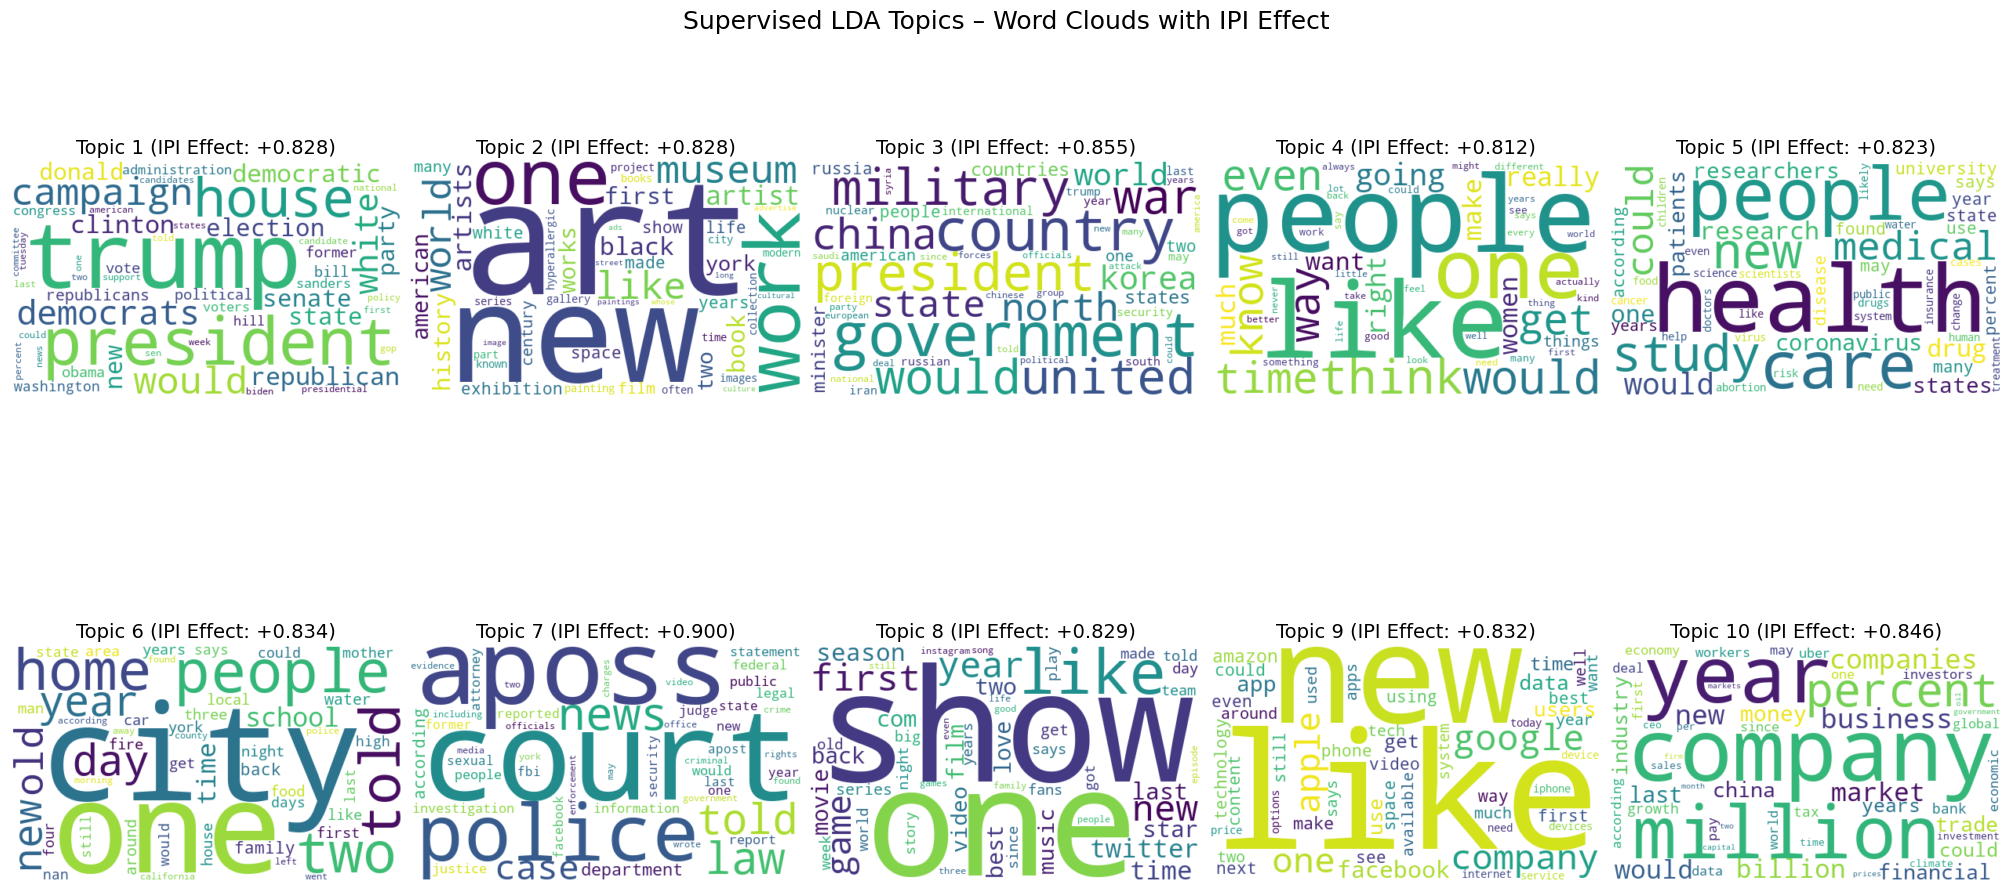

In [8]:
# Visualize the top topics and their relationship to the IPI values
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    # Get topic words and their weights
    if idx < num_topics:  # Make sure we don't exceed the number of topics
        # Get the top 50 words for this topic
        top_words = slda_model.get_topic_words(idx, top_n=50)
        
        # Create dictionary for the wordcloud
        topic_dict = {word: weight for word, weight in top_words}
        
        # Create wordcloud
        wc = WordCloud(width=500, height=300, background_color='white', max_words=50)
        wc.generate_from_frequencies(topic_dict)
        ax.imshow(wc, interpolation='bilinear')
        
        # Add title with regression coefficient to show topic-IPI relationship
        coef = topic_coefs[idx]
        coef_sign = "+" if coef > 0 else ""
        ax.set_title(f'Topic {idx + 1} (IPI Effect: {coef_sign}{coef:.3f})', fontsize=14)
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off extra subplots if any

plt.suptitle('Supervised LDA Topics – Word Clouds with IPI Effect', fontsize=18)
plt.show()

In [9]:
# Save the model
import os

# Create directory if it doesn't exist
os.makedirs("../models/topic_model", exist_ok=True)

# Save the sLDA model using tomotopy's native save method
slda_model.save("../models/topic_model/slda_model")

print("Model saved")

Model saved


### Topic Extraction & Analysis

In [10]:
# Step 1: Extract document-topic distributions for each article
doc_topic_dists = []
for doc in slda_model.docs:
    doc_topic_dists.append(doc.get_topic_dist())

# Create topic column names
topic_cols = [f'topic_{i}' for i in range(num_topics)]

# Create a DataFrame with topic distributions
df_topics = pd.DataFrame(doc_topic_dists, columns=topic_cols)

# Combine with metadata
df_meta = df_merged[['date', 'publication', 'month']].reset_index(drop=True).copy()  # Using existing columns
# Only keep rows for which we have topic distributions (some might have been filtered out)
df_meta = df_meta.iloc[:len(doc_topic_dists)].copy()

df_combined = pd.concat([df_meta, df_topics], axis=1)

# Aggregate topic shares by month and publisher
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Save to CSV with tomotopy_sLDA in the filename
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_sLDA.csv', index=False)

print("Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'")

# Display the head of the saved CSV file
df_check_csv = pd.read_csv('../data/processed/monthly_topic_shares_by_publisher_sLDA.csv')
print("Head of 'monthly_topic_shares_by_publisher_sLDA.csv':")
df_check_csv.head()

Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'
Head of 'monthly_topic_shares_by_publisher_sLDA.csv':


,month,publication,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2016-01,Business Insider,0.011177,0.033370,0.079773,0.097302,0.074727,0.098848,0.103577,0.145640,0.144397,0.211189
1,2016-01,CNBC,0.077620,0.006541,0.070780,0.080099,0.067432,0.057566,0.065173,0.030000,0.051948,0.492840
2,2016-01,CNN,0.246734,0.025729,0.148172,0.097992,0.076219,0.111124,0.125382,0.066957,0.043887,0.057804
3,2016-01,Economist,0.054624,0.092408,0.274799,0.152614,0.038277,0.093722,0.038525,0.036632,0.055162,0.163236
4,2016-01,Gizmodo,0.030501,0.068285,0.028256,0.108532,0.118862,0.074730,0.098407,0.045594,0.361619,0.065214


### Compare topic trends with IPI values

/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_70290/1208111105.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(months, rotation=90)


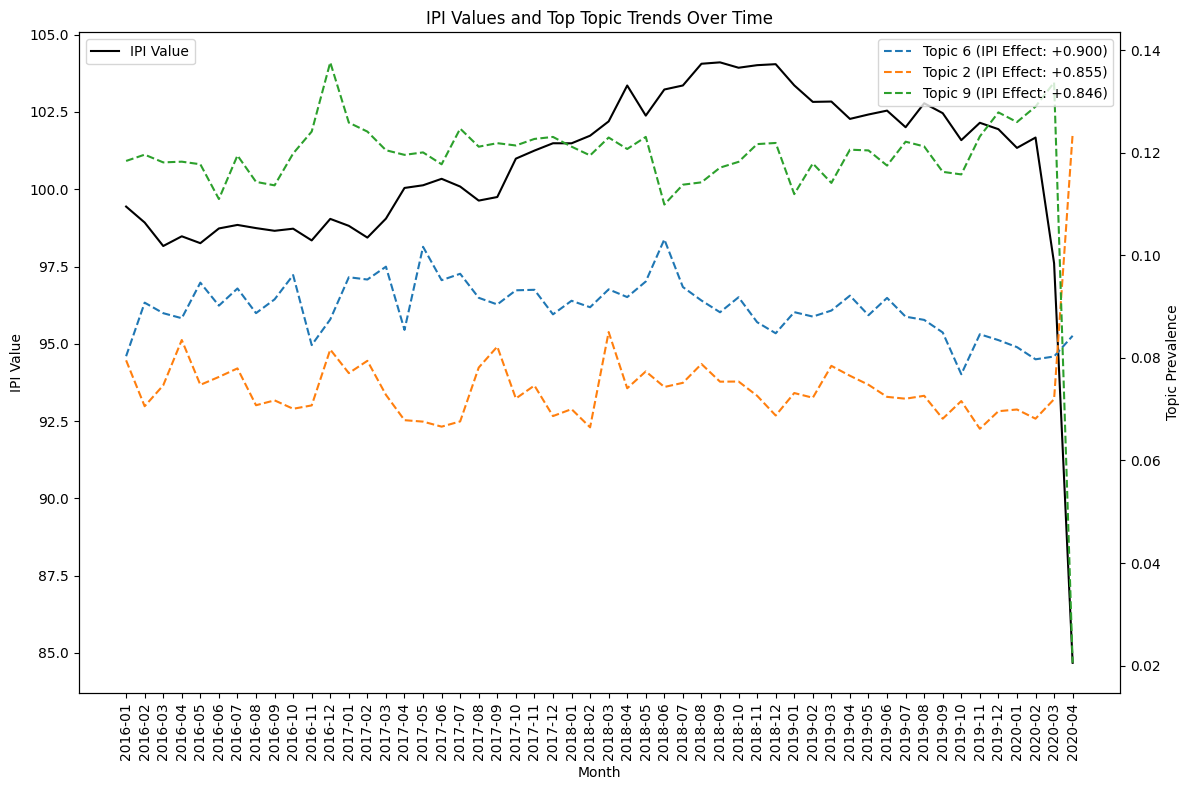

In [11]:
# Analyze the relationship between topic prevalence and IPI values

# Get average IPI by month
monthly_ipi = df_ipi.groupby('month')['ipi_value'].mean().reset_index()

# Get average topic distributions by month (across all publishers)
monthly_topics = df_monthly_pub.groupby('month')[topic_cols].mean().reset_index()

# Merge the data
df_trends = pd.merge(monthly_topics, monthly_ipi, on='month', how='inner')

# Plot the trends of the top 3 most influential topics (based on regression coefficients)
topic_importance = [(i, abs(c)) for i, c in enumerate(topic_coefs)]
top_topics = sorted(topic_importance, key=lambda x: x[1], reverse=True)[:3]

plt.figure(figsize=(12, 8))

# Plot IPI values
ax1 = plt.gca()
ax2 = ax1.twinx()

months = df_trends['month'].astype(str).tolist()
ax1.plot(months, df_trends['ipi_value'], 'k-', label='IPI Value')

# Plot topic trends
for topic_idx, importance in top_topics:
    topic_col = f'topic_{topic_idx}'
    coef = topic_coefs[topic_idx]
    coef_sign = "+" if coef > 0 else ""
    ax2.plot(months, df_trends[topic_col], '--', 
            label=f'Topic {topic_idx} (IPI Effect: {coef_sign}{coef:.3f})')

ax1.set_xlabel('Month')
ax1.set_ylabel('IPI Value')
ax2.set_ylabel('Topic Prevalence')
ax1.set_xticklabels(months, rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('IPI Values and Top Topic Trends Over Time')
plt.tight_layout()
plt.show()

### Output

The output CSV file (`monthly_topic_shares_by_publisher_sLDA.csv`) contains the monthly topic distributions for each publisher, which can be used for further analysis or visualization.